**Chapter 13 – Convolutional Neural Networks**

_This notebook contains all the sample code and solutions to the exercices in chapter 13._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

And of course we will need TensorFlow:

In [3]:
import tensorflow as tf

# Convolutional layer

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

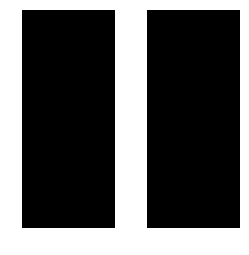

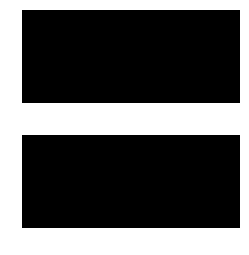

In [34]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
fmap[:, :, 0, 0]
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

In [35]:
# tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME", use_cudnn_on_gpu=False)

In [7]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

Saving figure china_original


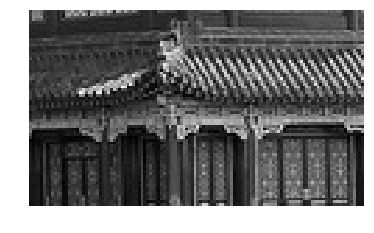

In [8]:
plot_image(images[0, :, :, 0])
save_fig("china_original", tight_layout=False)
plt.show()

Saving figure china_vertical


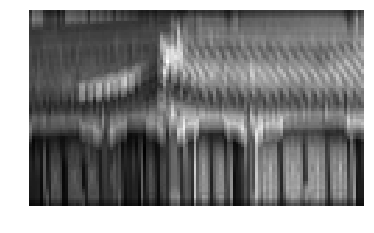

In [9]:
plot_image(output[0, :, :, 0])
save_fig("china_vertical", tight_layout=False)
plt.show()

Saving figure china_horizontal


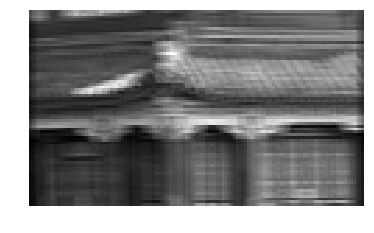

In [10]:
plot_image(output[0, :, :, 1])
save_fig("china_horizontal", tight_layout=False)
plt.show()

## Simple example

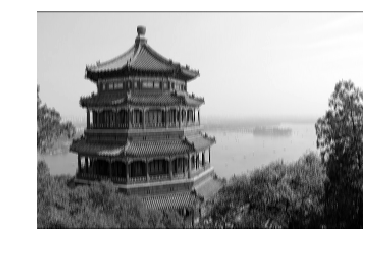

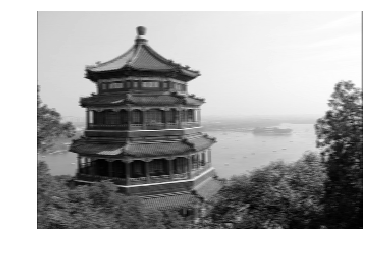

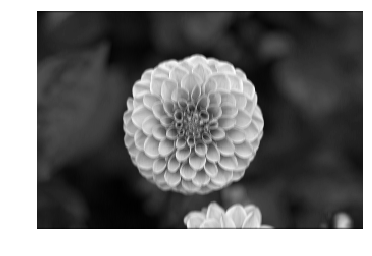

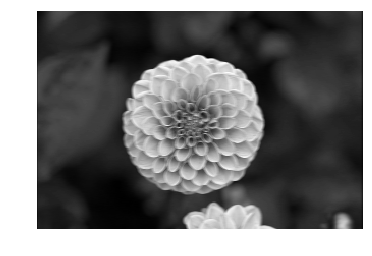

In [48]:
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

## VALID vs SAME padding

In [12]:
tf.reset_default_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[ 184.]
   [ 389.]]]]
SAME:
 [[[[ 143.]
   [ 348.]
   [ 204.]]]]


In [13]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))


VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


# Pooling layer

Saving figure china_original


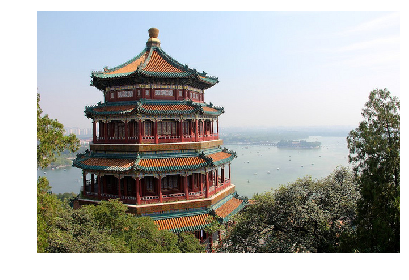

Saving figure china_max_pool


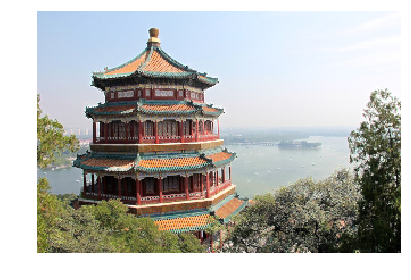

In [14]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plot_color_image(dataset[0])
save_fig("china_original")
plt.show()
    
plot_color_image(output[0])
save_fig("china_max_pool")
plt.show()

# MNIST

In [15]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
X_train, X_test = mnist["data"][:60000].astype(np.float64), mnist["data"][60000:].astype(np.float64)
y_train, y_test = mnist["target"][:60000].astype(np.int64), mnist["target"][60000:].astype(np.int64)

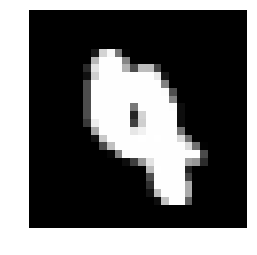

In [16]:
height, width = 28, 28
images = X_test[5000].reshape(1, height, width, 1)
plot_image(images[0, :, :, 0])

# Inception v3

In [44]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [45]:
fetch_pretrained_inception_v3()

TypeError: makedirs() got an unexpected keyword argument 'exist_ok'

In [38]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join("datasets","inception","imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [39]:
class_names = load_class_names()

In [40]:
width = 299
height = 299
channels = 3

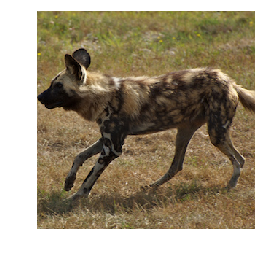

In [41]:
import matplotlib.image as mpimg
test_image = mpimg.imread(os.path.join("images","cnn","test_image.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [42]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [43]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for datasets/inception/inception_v3.ckpt
	 [[Node: save/RestoreV2_156 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_156/tensor_names, save/RestoreV2_156/shape_and_slices)]]

Caused by op u'save/RestoreV2_156', defined at:
  File "/Users/edwin/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/edwin/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-8d2bd0be65c1>", line 10, in <module>
    saver = tf.train.Saver()
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1051, in __init__
    self.build()
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1081, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/edwin/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for datasets/inception/inception_v3.ckpt
	 [[Node: save/RestoreV2_156 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_156/tensor_names, save/RestoreV2_156/shape_and_slices)]]


In [ ]:
class_names[np.argmax(predictions_val[0])]

In [ ]:
np.argmax(predictions_val, axis=1)

In [ ]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = top_5[np.argsort(predictions_val[0][top_5])]
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100*predictions_val[0][i]))

# Exercise solutions

**Coming soon**